# Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from astropy import constants as const
import multiprocessing
import time


if os.path.exists("/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/platypos/"):
    sys.path.append("/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/platypos/")
elif os.path.exists("/work2/lketzer/work/gitlab/platypos_group/platypos/"):
    sys.path.append("/work2/lketzer/work/gitlab/platypos_group/platypos/")
elif os.path.exists("/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/platypos/"):
    sys.path.append("/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/platypos/")
import platypos
from platypos import Planet_LoFo14
from platypos import Planet_ChRo16
from platypos import Planet_Ot20
import platypos.planet_models_LoFo14 as plmoLoFo14
import platypos.planet_models_ChRo16 as plmoChRo16
from platypos.mass_evolution_function import mass_evo_RK4_forward
from platypos.mass_loss_rate_function import mass_loss_rate, mass_loss_rate_Elim, mass_loss_rate_RRlim, mass_loss_rate_noplanetobj
from platypos.lx_evo_and_flux import lx_evo, flux_at_planet, l_xuv_all
from platypos.mass_luminosity_relation import mass_lum_relation_mamajek
from platypos.lx_evo_and_flux import l_high_energy, calculate_Lx_sat

if os.path.exists("/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/"):
    sys.path.append("/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/")
elif os.path.exists("/work2/lketzer/work/gitlab/platypos_group/multitrack/"):
    sys.path.append("/work2/lketzer/work/gitlab/platypos_group/multitrack/")
elif os.path.exists("/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/"):
    sys.path.append("/home/laura/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/")
from multitrack import evolve_one_planet_along_one_track
#from multitrack import evolve_one_planet
from multitrack.create_planet_chunks import create_file_structure_for_saving_results_and_return_planet_folder_pairs
from multitrack.create_planet_chunks import make_folder_planet_track_list
from multitrack.create_planet_chunks import create_arg_list_one_planet, create_arg_list_one_planet_along_one_track

from multitrack.evolve_planet import evolve_1planet_1track
from multitrack.create_planet_chunks import create_arg_list_1planet_1track
from multitrack.complete_track_dict import complete_track_dict, complete_track_dict_noplobj

from multitrack.read_in_PLATYPOS_population_results import read_results_file, read_in_PLATYPOS_results_fullEvo
from multitrack.read_in_PLATYPOS_population_results import read_in_PLATYPOS_results_final
from multitrack.read_in_PLATYPOS_population_results import read_in_PLATYPOS_results_dataframe
from multitrack.read_in_PLATYPOS_population_results import get_complete_results
from multitrack.read_in_PLATYPOS_population_results import read_in_host_star_parameters
from multitrack.read_in_PLATYPOS_population_results import read_in_PLATYPOS_results_df_new, create_master_table

import multitrack.keplers_3rd_law as kepler3
import multitrack.get_ExoplanetEU_data as exoEU


#!pip install line_profiler
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

# Create Planets 
- specify host star properties
- specify planet properties: core mass, orbital mass fraction and orbital distance

In [3]:
star = {
 'star_id': "dummy",
 'mass': 0.9853484910214,
 'radius': None,
 'age': 1.0,
 'L_bol': 3.4539847848609653e+33/const.L_sun.cgs.value,
 'Lx_age': 2.56047429431498e+30}
planet = {
 'distance': 0.013243682995988661,
 'metallicity': 'solarZ',
 'fenv': 16.392784596958197,
 'core_mass': 0.9532237058218218}
pl1 = Planet_LoFo14(star, planet)

star = {
 'star_id': 'star_age1.0_mass1.03',
 'mass': 1.027672583692369,
 'radius': None,
 'age': 1.0,
 'L_bol': 4.0868258335169855e+33/const.L_sun.cgs.value,
 'Lx_age': 3.029605844799301e+30}
planet = {
 'distance': 0.26568969027997524,
 'metallicity': 'solarZ',
 'fenv': 2.2181748204555483,
 'core_mass': 2.274310743090016}
pl2 = Planet_LoFo14(star, planet)

star = {
 'star_id': 'star_age1.0_mass1.05',
 'mass': 1.0528330000727544,
 'radius': None,
 'age': 1.0,
 'L_bol': 4.6964654232268237e+33/const.L_sun.cgs.value,
 'Lx_age': 3.481537916153693e+30}
planet = {
 'distance': 0.08122846066224176,
 'metallicity': 'solarZ',
 'fenv': 7.4452478880800514,
 'core_mass': 3.5298972937511093}
pl3 = Planet_LoFo14(star, planet)

for pl in [pl1, pl2, pl3]:
    pl.Lx_sat_info = "Tu15"

In [4]:
pl2.__dict__

{'star_id': 'star_age1.0_mass1.03',
 'radius_star': None,
 'mass_star': 1.027672583692369,
 'age': 1.0,
 'Lbol': 4.0868258335169855e+33,
 'Lbol_solar': 1.0676138541057956,
 'Lx_age': 3.029605844799301e+30,
 'Lx_sat_info': 'Tu15',
 'Lx_sat_Lbol': None,
 'distance': 0.26568969027997524,
 'metallicity': 'solarZ',
 'flux': 14.993585465287188,
 'flux_cgs': 20586192.84383931,
 't_eq': 548.8783202065721,
 'has_evolved': False,
 'planet_id': 'dummy',
 'EUV_relation': None,
 'planet_type': 'LoFo14',
 'planet_info': 'Case 1 - artificial planet (with M_core & f_env)',
 'fenv': 2.2181748204555483,
 'core_mass': 2.274310743090016,
 'core_radius': 1.228039823926851,
 'mass': 2.325903345446851,
 'R_env': 3.07082251329571,
 'radius': 4.298862337222561,
 'density': 0.16087941358191246,
 'grav_potential': -338130643901.97174,
 'lambda_escape': 7.467228074912551,
 'radius_RL': 81.8505718243745,
 'period': 49.34368951975617}

# Set starting conditions for the simulation & define some activity tracks

In [7]:
# simulation run parameters
age_star = pl1.age
Lxsat_info, relation_EUV = "LxTu15", "Johnstone"
t_final, initial_step_size, epsilon = 7000., 0.1, 0.1
K = "yes"
beta_settings = {"beta_calc": "Lopez17", "RL_cut": True}
mass_loss_calc = "Elim_and_RRlim"
fenv_sample_cut = True

# track parameters which are different between the diff. tracks: t_sat, dt_drop, Lx_drop_factor
track1 = {'t_sat': 1.9513432987716333, 'dt_drop': 23.3, 'Lx_drop_factor': 37.657876399021}
track2 = {'t_sat': 4.097848550067654, 'dt_drop': 23.3, 'Lx_drop_factor': 32.93517012357806}
track3 = {'t_sat': 8.605539963092262, 'dt_drop': 23.3, 'Lx_drop_factor': 25.645501139747335}
track4 = {'t_sat': 18.071755740010293, 'dt_drop': 23.3, 'Lx_drop_factor': 16.73703522599636}
track5 = {'t_sat': 37.95094287253076, 'dt_drop': 23.3, 'Lx_drop_factor': 8.785921912518194}
track6 = {'t_sat': 79.69751725480509, 'dt_drop': 23.3, 'Lx_drop_factor': 3.7416155266187654}
track7 = {'t_sat': 167.36591440992555, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
track8 = {'t_sat': 351.47078944396685, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
track9 = {'t_sat': 500.0, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
track10 = {'t_sat': 100.0, 'dt_drop': 0.0, 'Lx_drop_factor': 0.0}
different_track_params_list = [track10]#[track1, track2, track3, track4, track5, track6, track7, track8, track9, track10]

# Evolve planets along all tracks

In [6]:
list_planets = [pl1, pl2, pl3]
name = "Planet_grid/"

if not os.path.isdir(os.getcwd() + "/" + name):
    os.makedirs(os.getcwd() + "/" + name)
else:
    os.system("rm -r " + os.getcwd() + "/" + name)
    os.makedirs(os.getcwd() + "/" + name)

path_save, folder_planet_list = create_file_structure_for_saving_results_and_return_planet_folder_pairs(
                                            curr_path=os.getcwd()+"/",
                                            folder_name=name,
                                            list_planets=list_planets)
print("\nPath for saving results:\n", path_save)

# create list of [folder, planet, track]-triplets
folder_planet_track_list =  make_folder_planet_track_list(
                                                    folder_planet_list,
                                                    different_track_params_list)

# for evolve_one_planet_along_one_track
arg_tuples = create_arg_list_1planet_1track(
                                folder_planet_track_list,
                                t_final,
                                initial_step_size,
                                epsilon, K, beta_settings,
                                path_save,
                                relation_EUV,
                                mass_loss_calc,
                                fenv_sample_cut)

Folder test_run/ exists.

Path for saving results:
 /media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/example/test_run/


In [11]:
arg_tuples[0]

(['planet_1',
  {'t_sat': 1.9513432987716333,
   'dt_drop': 23.3,
   'Lx_drop_factor': 37.657876399021}],
 10000.0,
 0.1,
 0.1,
 'yes',
 {'beta_calc': 'Lopez17', 'RL_cut': True},
 '/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/example/test_run/planet_1',
 'Johnstone',
 'Elim_and_RRlim',
 False)

In [15]:
tuple(0)

TypeError: 'int' object is not iterable

In [6]:
#start the multiprocessing
start = time.time()

if __name__ == '__main__': # Allows for the safe importing of the main module

    cpu_count = multiprocessing.cpu_count()
    print("There are %d CPUs on this machine" % cpu_count)

    with multiprocessing.Pool(processes=cpu_count-1) as pool:
        pool.starmap(evolve_1planet_1track, arg_tuples)

print(f'Time: {time.time() - start}')
print("\n")

There are 4 CPUs on this machine
Time: 19.72575855255127




# Read in the results

In [7]:
%%time
path_save = "/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/github/github_May21/multitrack/example/"

# specify run parameters (necessary to calculate some additional parameters)
add_parameters = {"epsilon": epsilon,
                  "beta_settings": beta_settings,
                  "K_on": K,
                  "mass_loss_calc": mass_loss_calc,
                  "relation_EUV": relation_EUV}

###
f = "test_run/"
pl_df, tracks_dict = read_in_PLATYPOS_results_df_new(os.path.join(path_save, f),
                                                  len(different_track_params_list),
                                                  return_second_to_last=False)
pl_more = create_master_table(pl_df, os.path.join(path_save, f),
                              len(different_track_params_list), add_parameters)
pl_df_dict, pl_init_dict, track_dict = read_in_PLATYPOS_results_fullEvo(os.path.join(path_save, f),
                                                                        len(different_track_params_list))

/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/github/github_May21/multitrack/example/test_run/
Total # of planet folders =  3
Non-empty folders:  3

Total number of planets to analyze:  3
Non-empty folders:  3
/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/github/github_May21/multitrack/example/test_run/
Total # of planet folders =  3
Non-empty folders:  3

Total number of planets to analyze:  3
CPU times: user 796 ms, sys: 29.7 ms, total: 826 ms
Wall time: 816 ms


# Plot results

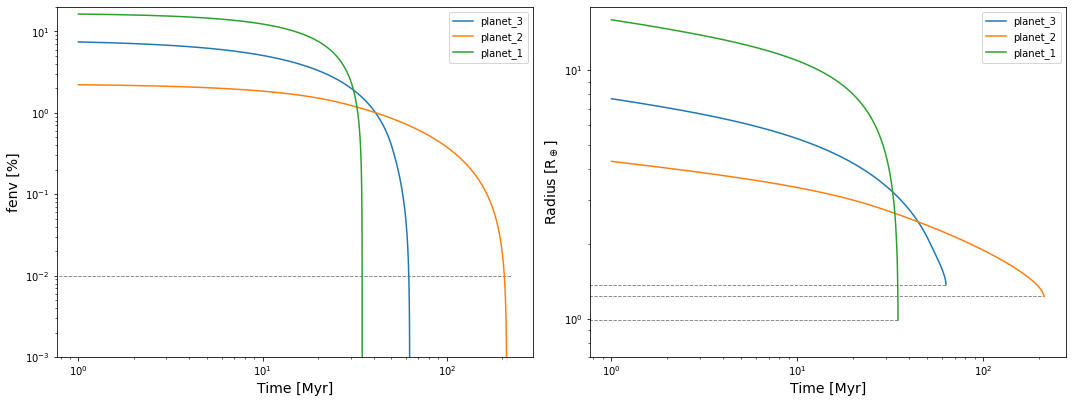

In [8]:
track = 10
fig, axs = plt.subplots(1,2, figsize=(15,6))

for pl in list(pl_df_dict.keys()):
    df_pl = pl_df_dict[pl]
    fenv = ((df_pl["M"+str(track)] - pl_df.loc[pl]["core_mass"]) / df_pl["M"+str(track)]) * 100
    axs[0].plot(df_pl["t"+str(track)], fenv, ls="-", marker="None", label=pl)
    
    axs[1].plot(df_pl["t"+str(track)], df_pl["R"+str(track)], ls="-", marker="None", label=pl)
    xlim = axs[1].get_xlim()
    xmax = df_pl["t"+str(track)].loc[df_pl["t"+str(track)].last_valid_index()]
    axs[1].hlines(plmoLoFo14.calculate_core_radius(pl_df.loc[pl]["core_mass"]), xlim[0], xmax, ls="--", lw=0.9, color="grey")

axs[0].hlines(1e-2, xlim[0], xlim[1], ls="--", lw=0.9, color="grey")
axs[0].set_ylim(1e-3, 20)
axs[0].set_ylabel("fenv [%]", size=14)

axs[1].set_ylim(0.7, 18)
axs[1].set_ylabel("Radius [R$_\oplus$]", size=14)
for ax in axs:
    #ax.set_xlim(8, 1e4)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Time [Myr]", size=14)
    ax.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.98]); 

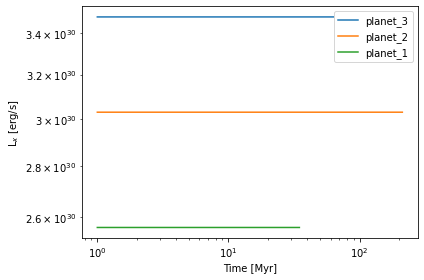

In [9]:
fig, ax = plt.subplots()
for pl in list(pl_df_dict.keys()):
    df_pl = pl_df_dict[pl]
    ax.plot(df_pl["t"+str(track)], df_pl["Lx"+str(track)], ls="-", marker="None", label=pl)

ax.set_yscale("log"); ax.set_xscale("log")
ax.set_ylabel("L$_x$ [erg/s]"); ax.set_xlabel("Time [Myr]")
ax.legend()
plt.tight_layout();